In [ ]:
#!pip install pandas scikit-learn matplotlib seaborn tensorflow scikeras

In [9]:
# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier # Import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

In [10]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [11]:
# --- 2. Data Loading and Initial Preprocessing ---
def load_and_initial_preprocess(file_path='dataset_tallas_ropa.csv'):
    """
    Loads the dataset and performs initial preprocessing steps.
    """
    df = pd.read_csv("Tallas.csv")

    # Drop irrelevant columns
    df = df.drop(columns=['ID_Usuario'])

    # Convert object types to category for better memory usage and explicit type handling
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype('category')
    return df

# Load the dataset
df = load_and_initial_preprocess()
display(df)

,Tipo_Prenda,Marca,Medida_Pecho_cm,Medida_Cintura_cm,Medida_Cadera_cm,Altura_cm,Peso_kg,Edad,Talla_Ropa_General,Talla_Zapatillas,Talla_Pantalones,Feedback_Ajuste
0,Camiseta,Zara,92.0,78.0,94.0,170.0,65.0,28.0,M,NaN,NaN,Perfecto
1,Pantalón,Levi's,NaN,88.0,102.0,175.0,78.0,35.0,NaN,NaN,32x32,Perfecto
2,Vestido,H&M,88.0,72.0,90.0,165.0,58.0,22.0,S,NaN,NaN,Perfecto
3,Zapatillas,Nike,NaN,NaN,NaN,180.0,85.0,30.0,NaN,44 EU,NaN,Demasiado ajustado
4,Camiseta,Hugo Boss,96.0,80.0,98.0,172.0,70.0,45.0,L,NaN,NaN,Demasiado grande
...,...,...,...,...,...,...,...,...,...,...,...,...
892,Pantalón,Carhartt,NaN,92.0,108.0,180.0,85.0,30.0,L,NaN,36,Demasiado grande
893,Zapatillas,Converse,NaN,NaN,NaN,NaN,NaN,NaN,EU,NaN,NaN,Demasiado grande
894,Vestido,Adolfo Dominguez,88.0,70.0,90.0,165.0,58.0,35.0,S,NaN,NaN,Demasiado ajustado
895,Camiseta,Nike,85.0,68.0,90.0,163.0,55.0,26.0,S,NaN,NaN,Demasiado ajustado


In [12]:
# --- 3. Feature Engineering & Data Splitting ---
def prepare_features_and_split(df, target_column='Feedback_Ajuste', test_size=0.2, random_state=42):
    """
    Separates features and target, identifies column types, and splits data.
    """
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include='category').columns.tolist()

    # We need a validation set for early stopping, so split train into train/val as well
    # Or, KerasClassifier can use a validation_split directly in .fit()
    # For simplicity with KerasClassifier, we'll keep the initial split and let KerasClassifier
    # handle internal validation split if `validation_split` is passed.
    # However, it's generally cleaner to explicitly split X_train, y_train into train/val.
    # For now, let's just make sure y_train and y_test are encoded.

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Encode target labels if they are not already numerical (required for Keras and some scikit-learn metrics)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    # Store original class names for later use
    class_names = le.classes_

    return X_train, X_test, y_train_encoded, y_test_encoded, numerical_cols, categorical_cols, class_names, le

X_train, X_test, y_train_encoded, y_test_encoded, numerical_cols, categorical_cols, class_names, label_encoder = prepare_features_and_split(df)
y_all_encoded = label_encoder.transform(df['Feedback_Ajuste']) # Encode full y for cross-validation

In [13]:
# --- 4. Preprocessing Pipelines Definition ---
def define_preprocessing_pipelines(numerical_cols, categorical_cols):
    """
    Defines the preprocessing pipelines for numerical and categorical features.
    """
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        remainder='passthrough'
    )
    return preprocessor

preprocessor = define_preprocessing_pipelines(numerical_cols, categorical_cols)

In [14]:
# --- 5. TensorFlow Model Definition ---
def create_keras_model(input_dim, num_classes):
    """
    Builds and compiles a Keras Sequential model.
    """
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy as y is integer encoded
                  metrics=['accuracy'])
    return model

# Determine the number of output classes
num_classes = len(class_names)

# Get the number of features after preprocessing to set input_dim for Keras model
# We need to fit a temporary preprocessor to get the output shape
temp_preprocessor_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
temp_preprocessor_pipeline.fit(X_train) # Fit preprocessor on X_train
X_train_transformed_shape = temp_preprocessor_pipeline.transform(X_train[:1]).shape[1] # Get shape from one sample

# Define EarlyStopping callback
# monitor='val_loss' (o 'val_accuracy'): Métrica a monitorear en el conjunto de validación.
# patience: Número de épocas sin mejora después de las cuales el entrenamiento se detendrá.
# restore_best_weights=True: Restaurar los pesos del modelo de la época con el mejor rendimiento.
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Puedes cambiar a 'val_accuracy' si lo prefieres
    patience=10,        # Número de épocas a esperar sin mejora
    restore_best_weights=True,
    verbose=1           # Muestra mensajes cuando se activa la parada temprana
)

# Create the KerasClassifier wrapper
keras_classifier_model = KerasClassifier(
    model=create_keras_model,
    input_dim=X_train_transformed_shape,
    num_classes=num_classes,
    epochs=100, # Aumentamos las épocas máximas porque EarlyStopping lo detendrá
    batch_size=32,
    verbose=0, # Set to 1 for training progress per epoch, 0 for silent
    callbacks=[early_stopping_callback], # Pass the early stopping callback here
    validation_split=0.2 # KerasClassifier will split 20% of X_train for validation
)
# Create the final pipeline with the KerasClassifier
model_tf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', keras_classifier_model)])

Training TensorFlow Model...


c:\Users\hugoa\Desktop\MasterIA\TallasCharlaDesarrollo\IAVenv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 33.
TensorFlow Model Trained!


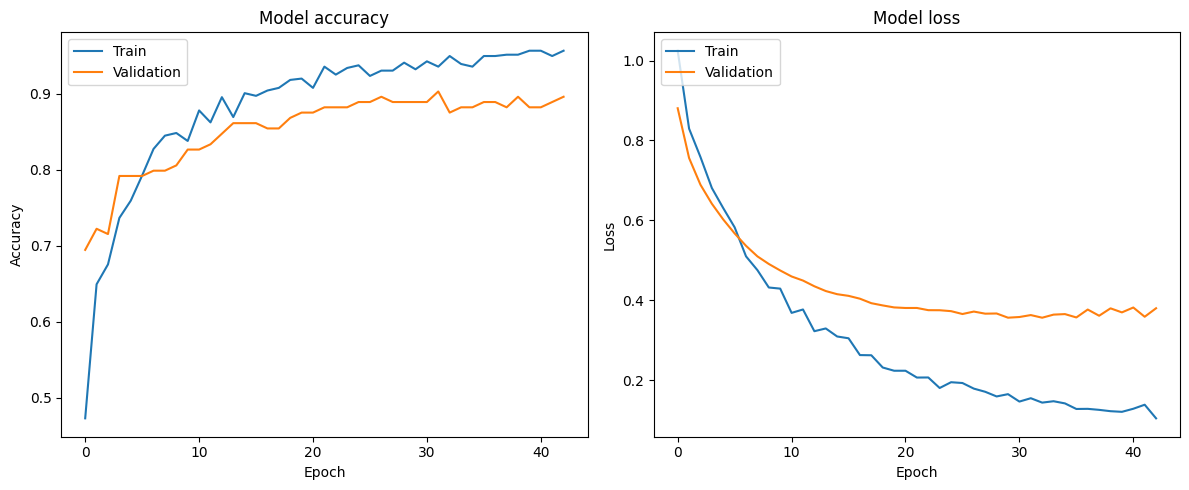

In [15]:
# --- 6. Model Training ---
print("Training TensorFlow Model...")
# history aquí es el objeto Pipeline, no el historial de Keras directamente
model_tf.fit(X_train, y_train_encoded)
print("TensorFlow Model Trained!")

# --- Plotting Training History ---
def plot_training_history(pipeline_model): # Cambiamos el nombre del parámetro a 'pipeline_model' para mayor claridad
    """
    Plots the training and validation accuracy and loss over epochs.
    """
    # Acceder al KerasClassifier dentro de la Pipeline y luego a su historial
    hist = pipeline_model.named_steps['classifier'].history_ 

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(hist['accuracy'])
    plt.plot(hist['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_training_history(model_tf) # Pasamos el objeto Pipeline directamente


--- TensorFlow Model Performance ---
Accuracy: 0.85
Precision (weighted): 0.8545579911996891
Recall (weighted): 0.85
F1-Score (weighted): 0.8502822465189515

Classification Report:
                     precision    recall  f1-score   support

Demasiado ajustado       0.81      0.94      0.87        47
  Demasiado grande       0.76      0.78      0.77        36
          Perfecto       0.91      0.84      0.87        97

          accuracy                           0.85       180
         macro avg       0.83      0.85      0.84       180
      weighted avg       0.85      0.85      0.85       180



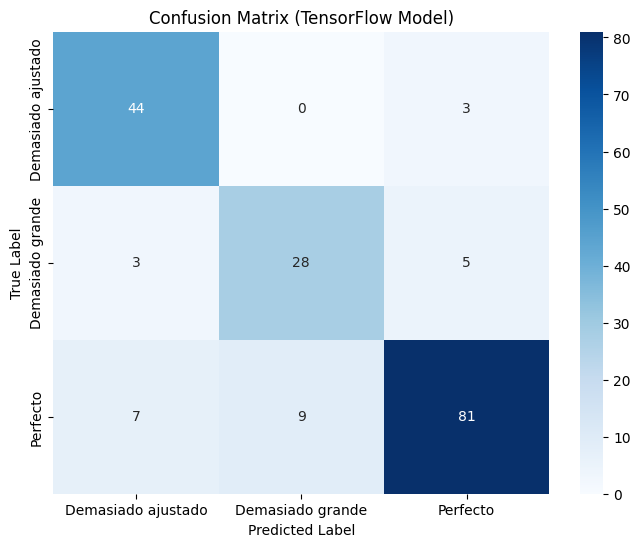

In [16]:
# --- 7. Model Evaluation ---
def evaluate_model(model, X_test, y_test_encoded, class_names):
    """
    Evaluates the trained model and prints performance metrics.
    """
    y_pred_tf = model.predict(X_test)

    # For KerasClassifier, predict usually returns class labels directly
    # If it returns probabilities, convert to labels: y_pred_classes_tf = np.argmax(y_pred_tf, axis=1)
    y_pred_classes_tf = y_pred_tf

    print("\n--- TensorFlow Model Performance ---")
    print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes_tf))
    print("Precision (weighted):", precision_score(y_test_encoded, y_pred_classes_tf, average='weighted', zero_division=0))
    print("Recall (weighted):", recall_score(y_test_encoded, y_pred_classes_tf, average='weighted', zero_division=0))
    print("F1-Score (weighted):", f1_score(y_test_encoded, y_pred_classes_tf, average='weighted', zero_division=0))

    print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_classes_tf, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm_tf = confusion_matrix(y_test_encoded, y_pred_classes_tf)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (TensorFlow Model)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

evaluate_model(model_tf, X_test, y_test_encoded, class_names)

In [ ]:
# --- 8. Cross-Validation ---
def perform_cross_validation(model, X, y_encoded, n_splits=5, random_state=42):
    """
    Performs stratified K-Fold cross-validation on the model.
    """
    print("\n--- Cross-Validation with TensorFlow Model ---")
    cv_scores_tf = cross_val_score(model, X, y_encoded, cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state), scoring='accuracy')

    print(f"Cross-validation accuracy scores (TensorFlow): {cv_scores_tf}")
    print(f"Mean CV accuracy (TensorFlow): {np.mean(cv_scores_tf):.4f}")
    print(f"Standard deviation of CV accuracy (TensorFlow): {np.std(cv_scores_tf):.4f}")

perform_cross_validation(model_tf, x, y_all_encoded) # Use full data for cross-validation


NameError: name 'X' is not defined

In [ ]:
# --- 9. Prediction on New Data ---
def predict_new_data(model, new_data_df, label_encoder):
    """
    Makes predictions on new, unseen data using the trained model.
    """
    print("\n--- Prediction on New Data (TensorFlow Model) ---")

    print("\nNew data for prediction:")
    print(new_data_df)

    # Convert pd.NA to np.nan (important for SimpleImputer)
    new_data_processed = new_data_df.replace({pd.NA: np.nan})

    # Make predictions using the TensorFlow pipeline
    predictions_tf = model.predict(new_data_processed)

    # Convert numerical predictions back to original labels
    predicted_labels_tf = label_encoder.inverse_transform(predictions_tf)

    print("\nPredicted Talla_Real for new data (TensorFlow Model):")
    for i, pred_label in enumerate(predicted_labels_tf):
        print(f"Sample {i+1}: {pred_label}")

# Define new data
new_data = pd.DataFrame({
    'Tipo_Prenda': ['Camiseta', 'Pantalón', 'Vestido'],
    'Marca': ['Zara', "Levi's", 'Mango'],
    'Medida_Pecho_cm': [112, pd.NA, 86],
    'Medida_Cintura_cm': [80, 90, 70],
    'Medida_Cadera_cm': [150, 105, 89],
    'Altura_cm': [150, 180, 163],
    'Peso_kg': [100, 80, 56],
    'Edad': [30, 35, 22],
    'Talla_Ropa_General': ['S', pd.NA,  "L"],
    'Talla_Zapatillas': [ pd.NA,  pd.NA,  pd.NA],
    'Talla_Pantalones': [ pd.NA, '34x34',  pd.NA]
})

predict_new_data(model_tf, new_data, label_encoder)